In [121]:
# ============================================================
# 📌 Paso 1: Importar librerías
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


In [122]:
# ============================================================
# 📌 Paso 2: Cargar el dataset
# ============================================================
# Ajusta la ruta al archivo en tu entorno local o en Google Colab
path = "C:\\Users\\ADM\\Documents\\Nasa\\Exoplanet-detection-using-AI\\data\\cumulative_2025.10.04_05.21.55.csv"

df = pd.read_csv(path, comment='#', low_memory=False)
df.head()


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [123]:
# ============================================================
# 📌 Paso 3: Crear la etiqueta (Confirmed / Candidate = 1, False = 0)
# ============================================================

def map_label(v):
    if pd.isna(v):
        return np.nan
    s = str(v).upper().strip()
    if 'CONFIRMED' in s:
        return 1
    if 'CANDID' in s:
        return 1
    if 'FALSE' in s and 'POS' in s:
        return 0
    if s in ['FALSE','NO','N','NONE','0']:
        return 0
    if s in ['TRUE','YES','Y','1']:
        return 1
    return 1

# detectar la columna de disposición
label_col = 'koi_disposition' if 'koi_disposition' in df.columns else [c for c in df.columns if 'disposition' in c.lower()][0]

df['target'] = df[label_col].apply(map_label)
df = df[df['target'].notna()].copy()

df[['target', label_col]].head(10)


,target,koi_disposition
0,1,CONFIRMED
1,1,CONFIRMED
2,1,CANDIDATE
3,0,FALSE POSITIVE
4,1,CONFIRMED
5,1,CONFIRMED
6,1,CONFIRMED
7,1,CONFIRMED
8,0,FALSE POSITIVE
9,1,CONFIRMED


In [124]:
# ============================================================
# 📌 Paso 4: Selección de variables numéricas
# ============================================================
# Excluir explícitamente columnas que no queremos usar como features numéricas
excluded_cols = {label_col, 'target', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'}
cand_cols = [c for c in df.columns if c not in excluded_cols]
num_cols = []

for c in cand_cols:
    coerced = pd.to_numeric(df[c], errors='coerce')
    if coerced.isna().mean() < 0.9 and coerced.nunique(dropna=True)>1:
        df[c+"_num"] = coerced
        num_cols.append(c+"_num")

X_all = df[num_cols].fillna(df[num_cols].median())
y = df['target'].astype(int)

print("Número de features numéricos:", len(num_cols))


Número de features numéricos: 37


In [125]:
# ============================================================
# 📌 Paso 5: Seleccionar las features más correlacionadas
# ============================================================
corrs = X_all.corrwith(y).abs().sort_values(ascending=False)
top_cols = corrs.index[:20].tolist()  # antes eran 10, ahora 20
X = X_all[top_cols].copy()
print("Top features:", top_cols)

Top features: ['koi_steff_err1_num', 'koi_steff_err2_num', 'koi_teq_num', 'koi_depth_num', 'koi_model_snr_num', 'koi_tce_plnt_num_num', 'koi_steff_num', 'koi_slogg_err2_num', 'koi_duration_num', 'ra_num', 'koi_slogg_num', 'koi_slogg_err1_num', 'koi_impact_err1_num', 'koi_srad_err1_num', 'dec_num', 'kepid_num', 'koi_srad_err2_num', 'koi_srad_num', 'koi_period_err1_num', 'koi_period_err2_num']


In [126]:
# ============================================================
# 📌 Paso 6: Preparar dataset de entrenamiento
# ============================================================
# Reducimos el tamaño para entrenar rápido (útil en deadline corto)
max_train = 9564
if X.shape[0] > max_train:
    # Submuestreamos de forma segura: train_test_split con train_size <= n_samples
    X, _, y, _ = train_test_split(X, y, stratify=y, train_size=max_train, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [127]:
# ============================================================
# 📌 Paso 7: Definir y entrenar la red neuronal
# ============================================================
mlp = MLPClassifier(
    hidden_layer_sizes=(32,16),  # antes era (16,)
    max_iter=300,                # antes 100
    random_state=42
)
# Usar sample weights en lugar de class_weight (MLPClassifier no acepta class_weight)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)
mlp.fit(X_train_s, y_train, sample_weight=sample_weight)

,hidden_layer_sizes,"(32, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [128]:
# ============================================================
# 📌 Paso 8: Evaluación del modelo
# ============================================================
y_pred = mlp.predict(X_test_s)
y_proba = mlp.predict_proba(X_test_s)[:,1]

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       968
           1       0.84      0.82      0.83       945

    accuracy                           0.83      1913
   macro avg       0.83      0.83      0.83      1913
weighted avg       0.83      0.83      0.83      1913

Matriz de confusión:
[[819 149]
 [167 778]]
ROC AUC: 0.9168164327255236


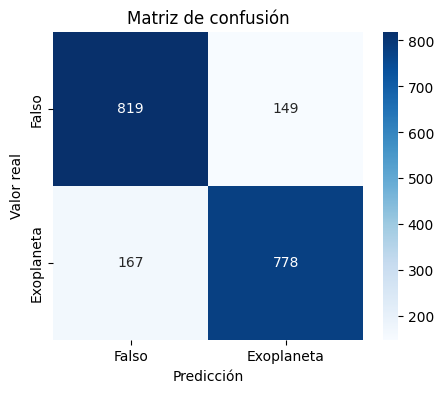

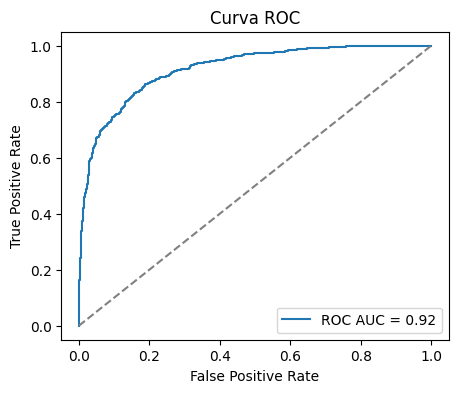

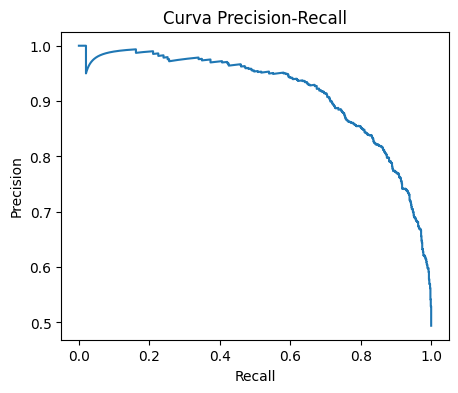

In [129]:
# ============================================================
# 📌 Paso 9: Guardar el modelo entrenado
# ============================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Falso","Exoplaneta"],
            yticklabels=["Falso","Exoplaneta"])
plt.title("Matriz de confusión")
plt.ylabel("Valor real")
plt.xlabel("Predicción")
plt.show()

# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test,y_proba):.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

# --- Precision-Recall ---
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.show()


In [130]:
#seleccionar renglon de set de test y mostrar valor real y predicción
def mostrar_valores_prediccion(idx):
    if idx < 0 or idx >= len(X_test):
        print("Índice fuera de rango.")
        return
    fila = X_test.iloc[idx]
    valor_real = y_test.iloc[idx]
    prediccion = mlp.predict(scaler.transform([fila]))[0]
    probabilidad = mlp.predict_proba(scaler.transform([fila]))[0][1]
    #comparar valores reales a valores predichos de los siguientes 20
    print(f"Índice: {idx}")
    print(f"Valor real: {valor_real}, Predicción: {prediccion}, Probabilidad de ser exoplaneta: {probabilidad:.4f}")   

    for i in range(1, 21):
        if idx + i < len(X_test):
            fila_siguiente = X_test.iloc[idx + i]
            valor_real_siguiente = y_test.iloc[idx + i]
            prediccion_siguiente = mlp.predict(scaler.transform([fila_siguiente]))[0]
            probabilidad_siguiente = mlp.predict_proba(scaler.transform([fila_siguiente]))[0][1]
            print(f"Índice: {idx + i}", f"Real: {valor_real_siguiente}, Pred: {prediccion_siguiente}, {probabilidad_siguiente*100:.4f}%")

# Ejemplo de uso:
#mostrar_valores_prediccion(30)  # Cambia el índice para probar otras filas   

#probar con datos que nunca haya visto, siendo estos los "ultimos" del dataset original

print("Últimos 5 registros del dataset original:")
# Usar solo las columnas top_cols para predecir, igual que en entrenamiento
for i in range(50):
    fila = X_all[top_cols].iloc[-(5-i)]
    valor_real = y.iloc[-(5-i)]
    prediccion = mlp.predict(scaler.transform([fila]))[0]
    probabilidad = mlp.predict_proba(scaler.transform([fila]))[0][1]
    print(f"Índice: {len(X_all)-(5-i)}")
    print(f"Valor real: {valor_real}, Predicción: {prediccion}, Probabilidad de ser exoplaneta: {probabilidad:.4f}")


Últimos 5 registros del dataset original:
Índice: 9559
Valor real: 0, Predicción: 0, Probabilidad de ser exoplaneta: 0.0203
Índice: 9560
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.5463
Índice: 9561
Valor real: 0, Predicción: 0, Probabilidad de ser exoplaneta: 0.0793
Índice: 9562
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.9060
Índice: 9563
Valor real: 0, Predicción: 0, Probabilidad de ser exoplaneta: 0.4878
Índice: 9564
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.9989
Índice: 9565
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.9994
Índice: 9566
Valor real: 1, Predicción: 0, Probabilidad de ser exoplaneta: 0.1709
Índice: 9567
Valor real: 0, Predicción: 0, Probabilidad de ser exoplaneta: 0.1942
Índice: 9568
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.9441
Índice: 9569
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.8770
Índice: 9570
Valor real: 1, Predicción: 1, Probabilidad 

c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warni

Guardado: models/feature_importances_by_weight.csv

Top 20 features por norma de pesos:
                 feature  weight_norm
0          koi_depth_num     2.586991
1      koi_srad_err2_num     2.435805
2       koi_duration_num     2.364537
3            koi_teq_num     2.226457
4    koi_impact_err1_num     2.192602
5     koi_slogg_err2_num     2.132517
6      koi_srad_err1_num     2.126183
7    koi_period_err1_num     2.097908
8          koi_slogg_num     2.077592
9      koi_model_snr_num     2.015811
10    koi_steff_err2_num     1.979709
11          koi_srad_num     1.975654
12         koi_steff_num     1.947542
13   koi_period_err2_num     1.941892
14    koi_steff_err1_num     1.696676
15    koi_slogg_err1_num     1.695398
16                ra_num     1.574071
17               dec_num     1.543902
18  koi_tce_plnt_num_num     1.333801
19             kepid_num     1.227052


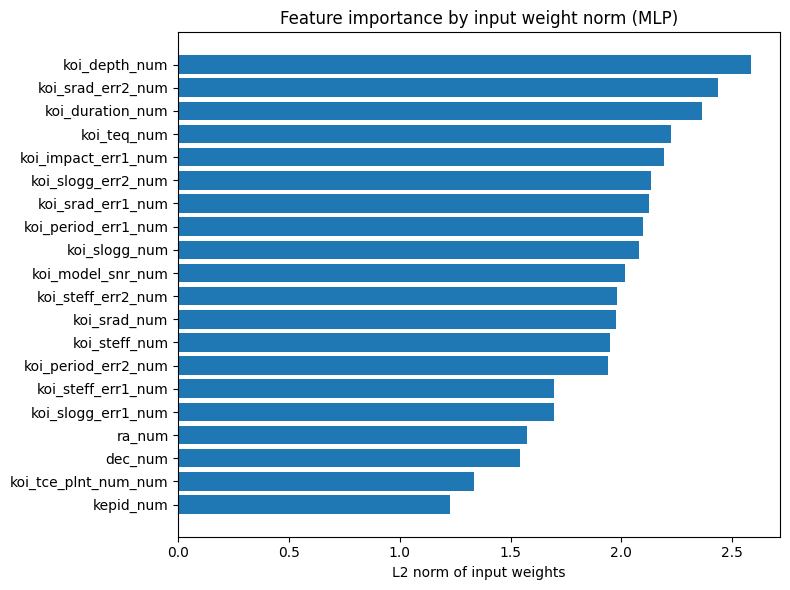


Computando Permutation Importance (esto puede tardar)...
Guardado: models/feature_importances_by_permutation.csv

Top 20 features por Permutation Importance:
                 feature  perm_importance
0            koi_teq_num         0.144188
1          koi_depth_num         0.105596
2     koi_steff_err1_num         0.083713
3       koi_duration_num         0.067754
4          koi_slogg_num         0.034588
5     koi_steff_err2_num         0.030614
6    koi_period_err1_num         0.028320
7          koi_steff_num         0.028279
8     koi_slogg_err2_num         0.024041
9    koi_impact_err1_num         0.022738
10     koi_srad_err1_num         0.016828
11   koi_period_err2_num         0.015993
12             kepid_num         0.015715
13               dec_num         0.015073
14    koi_slogg_err1_num         0.014293
15     koi_model_snr_num         0.011459
16     koi_srad_err2_num         0.010965
17          koi_srad_num         0.009145
18                ra_num         0.007617
1

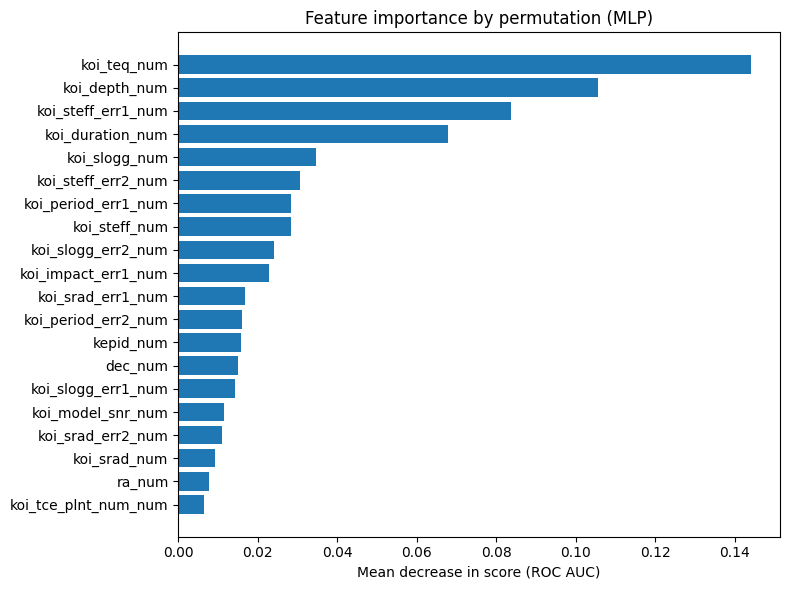


Comparativa (ordenada por weight_norm):
                 feature  weight_norm  perm_importance
0          koi_depth_num     2.586991         0.105596
1      koi_srad_err2_num     2.435805         0.010965
2       koi_duration_num     2.364537         0.067754
3            koi_teq_num     2.226457         0.144188
4    koi_impact_err1_num     2.192602         0.022738
5     koi_slogg_err2_num     2.132517         0.024041
6      koi_srad_err1_num     2.126183         0.016828
7    koi_period_err1_num     2.097908         0.028320
8          koi_slogg_num     2.077592         0.034588
9      koi_model_snr_num     2.015811         0.011459
10    koi_steff_err2_num     1.979709         0.030614
11          koi_srad_num     1.975654         0.009145
12         koi_steff_num     1.947542         0.028279
13   koi_period_err2_num     1.941892         0.015993
14    koi_steff_err1_num     1.696676         0.083713
15    koi_slogg_err1_num     1.695398         0.014293
16                ra_num

In [131]:
# ============================================================
# 📌 Paso 10: Importancia de features (pesos de la primera capa + Permutation Importance)
# ============================================================
import os
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# directorio para guardar resultados
os.makedirs('models', exist_ok=True)
# 1) Importancia basada en la norma L2 de los pesos de la capa de entrada
# mlp.coefs_ es una lista de arrays: (n_features, n_hidden1), (n_hidden1, n_hidden2), ...
w0 = mlp.coefs_[0]  # forma: (n_features, n_hidden_neurons)
# calcular la norma L2 por fila (cada fila corresponde a una feature de entrada)
feature_weight_norm = np.linalg.norm(w0, axis=1)
features = list(X_train.columns)
df_w = pd.DataFrame({'feature': features, 'weight_norm': feature_weight_norm})
df_w = df_w.sort_values('weight_norm', ascending=False).reset_index(drop=True)
df_w.to_csv('models/feature_importances_by_weight.csv', index=False)
print('Guardado: models/feature_importances_by_weight.csv')
# Mostrar top 20
print('\nTop 20 features por norma de pesos:')
print(df_w.head(20))
# gráfica
plt.figure(figsize=(8,6))
plt.barh(df_w['feature'].head(20)[::-1], df_w['weight_norm'].head(20)[::-1])
plt.xlabel('L2 norm of input weights')
plt.title('Feature importance by input weight norm (MLP)')
plt.tight_layout()
plt.show()
# 2) Permutation Importance (usa el clasificador entrenado y el set de test escalado)
# Esto puede ser costoso; usamos n_repeats=10 por defecto
print('\nComputando Permutation Importance (esto puede tardar)...')
r = permutation_importance(mlp, X_test_s, y_test, n_repeats=10, random_state=42, scoring='roc_auc')
perm_means = r.importances_mean
df_p = pd.DataFrame({'feature': features, 'perm_importance': perm_means})
df_p = df_p.sort_values('perm_importance', ascending=False).reset_index(drop=True)
df_p.to_csv('models/feature_importances_by_permutation.csv', index=False)
print('Guardado: models/feature_importances_by_permutation.csv')
print('\nTop 20 features por Permutation Importance:')
print(df_p.head(20))
# gráfica
plt.figure(figsize=(8,6))
plt.barh(df_p['feature'].head(20)[::-1], df_p['perm_importance'].head(20)[::-1])
plt.xlabel('Mean decrease in score (ROC AUC)')
plt.title('Feature importance by permutation (MLP)')
plt.tight_layout()
plt.show()
# Mostrar comparación lado a lado para top features comunes
top_w = df_w['feature'].head(20).tolist()
top_p = df_p['feature'].head(20).tolist()
union_top = list(dict.fromkeys(top_w + top_p))[:30]  # mantener orden y limitar
cmp_df = pd.DataFrame({'feature': union_top})
cmp_df = cmp_df.merge(df_w[['feature','weight_norm']], on='feature', how='left')
cmp_df = cmp_df.merge(df_p[['feature','perm_importance']], on='feature', how='left')
print('\nComparativa (ordenada por weight_norm):')
print(cmp_df)
cmp_df.to_csv('models/feature_importances_comparison.csv', index=False)
print('Guardado: models/feature_importances_comparison.csv')
# Guardar el scaler y el modelo si se desea (ya importaste joblib) - opcional
# joblib.dump(mlp, 'models/mlp_model.joblib')
# joblib.dump(scaler, 'models/scaler.joblib')
print('\nListo. Revisa la carpeta models/ para los CSV y observa las gráficas arriba.')